In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
import SenseEmb

In [4]:
import json
import os
import pickle
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from icecream import ic
from tqdm.auto import tqdm
from itertools import chain, islice
from collections import Counter
from CwnGraph import CwnSense

In [5]:
plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["axes.unicode_minus"] = False

In [6]:
import igraph as ig

In [8]:
# show that igraph computes the shortest path by following the path of least weight.
gg = ig.Graph(directed=False)
gg.add_vertices([0,1,2])
gg.add_edges([(0,1), (0,2), (1,2)])
gg.es["weight"] = [1,3,1]
print(gg)
gg.get_shortest_paths(0, 2, weights="weight")
# gg.add_edge(0, 2, weight=1)

IGRAPH UNW- 3 3 --
+ attr: name (v), weight (e)
+ edges (vertex names):
0--1, 0--2, 1--2


[[0, 1, 2]]

## Load cache data

In [7]:
skv = SenseEmb.SenseKeyedVectors.load_from_kv("../data/sense-emb-asbc5-600k-d50.kv")

In [9]:
with open("../data/sense_graph/sense_graph.pkl", "rb") as fin:    
    sG = pickle.load(fin)
with open("../data/sense_graph/sense_graph_centrality.pkl", "rb") as fin:    
    cents = pickle.load(fin)
    sense_key = cents["sense"]
    sfreq = [skv.get_vecattr(x, "count") for x in sense_key]
with open("../data/sense_graph/sense_graph_monosyll.pkl", "rb") as fin:    
    mw_items = pickle.load(fin)    
with open("../data/sense_graph/sense_graph_bisyll.pkl", "rb") as fin:    
    bw_items = pickle.load(fin)    

## Construct sense graph

In [9]:
## Extract vectors of senses (excl. word vectors)
idx_list = []
sense_key = []
for tok_i, tok in enumerate(skv.index_to_key):
    if "-" not in tok or tok.index("-") < 1: continue
    idx_list.append(tok_i)
    sense_key.append(tok)

In [10]:
sfreq = skv.expandos["count"][np.array(idx_list)]
svecs = skv.vectors[np.array(idx_list)]
svecs /= la.norm(svecs, axis=1)[:, np.newaxis]

In [11]:
import umap
proj = umap.UMAP(n_neighbors=10, metric="cosine", transform_mode="graph")
sAdj = proj.fit_transform(svecs)
# transform the probability to edge weight, i.e. the higher the weight, the higher the cost, 
# and the weaker the connection
sAdj.data = 1 + (1-sAdj.data)

In [12]:
sG = ig.Graph.Weighted_Adjacency(sAdj, mode=ig.ADJ_UNDIRECTED)
print(sG.summary())

sense_ids = {x[x.index('-')+1:]: i for i, x in enumerate(sense_key)}
edge_added = set()
e_rels = []

for k, v in skv.cwn.E.items():
    if k[0] in sense_ids and k[1] in sense_ids:
        rel_type = v["edge_type"]
        if rel_type not in "synonym,hypernym,hyponym":
            continue
        if rel_type in "hypernym,hyponym":
            rel_type = "hyper/hypo"
        src_id, tgt_id = sense_ids[k[0]], sense_ids[k[1]]
        
        eid = sG.get_eid(src_id, tgt_id, error=False)     
        if eid >= 0:
            # edge already exists
            sG.es[eid]["relation"] = rel_type
            sG.es[eid]["weight"] = 1.0
        else:
            edge_key = tuple(sorted([src_id, tgt_id]))
            if edge_key not in edge_added:
                e_rels.append((src_id, tgt_id, rel_type))
                edge_added.add(edge_key)

print("edge weight is none: ", sum(x is None for x in sG.es["weight"]))
sG.add_edges([(x[0], x[1]) for x in e_rels])
sG.es["relation"] = ""
eid_set = Counter()
for rel_x in e_rels:
    eid = sG.get_eid(rel_x[0], rel_x[1])    
    eid_set.update([eid])    
    sG.es[eid]["relation"] = rel_x[2]
    sG.es[eid]["weight"] = 1.0
print("add semantic relations: ", len(e_rels))
print("edge weight is none", sum(x is None for x in sG.es["weight"]))
print(sG.summary())
print(Counter(sG.es["relation"]))

IGRAPH U-W- 18065 139260 -- 
+ attr: weight (e)
edge weight is none:  0
add semantic relations:  9126
edge weight is none 0
IGRAPH U-W- 18065 148386 -- 
+ attr: relation (e), weight (e)
Counter({'': 139260, 'synonym': 7119, 'hyper/hypo': 2007})


## Node centrality measures

In [13]:
ic("compute degree")
node_degree = sG.degree()
ic("compute closeness")
node_closeness = sG.closeness(weights="weight")
ic("compute betweenness")
node_betweenness = sG.betweenness(weights="weight")

ic| 'compute degree'
ic| 'compute closeness'
ic| 'compute betweenness'


In [14]:
if not (os.path.exists("../data/sense_graph/sense_graph.pkl") or
    os.path.exists("../data/sense_graph/sense_graph_centrality.pkl")):
    with open("../data/sense_graph/sense_graph.pkl", "wb") as fout:    
        pickle.dump(sG, fout)
    with open("../data/sense_graph/sense_graph_centrality.pkl", "wb") as fout:    
        pickle.dump({
                "sense": sense_key,
                "degree": node_degree, 
                "closeness": node_closeness, 
                "betweenness": node_betweenness}, fout)
else:
    print("file already exists, delete them to dump again")

In [15]:
len(sG.vs)

18065

In [17]:
cent_dfr = pd.DataFrame({
    "sense": sense_key,
    "degree": node_degree, 
    "closeness": node_closeness, 
    "betweenness": node_betweenness})
cent_dfr.head()
cent_dfr.to_csv("../data/sense_graph/sense_graph_centrality.csv", index=None)

## Compute monosyllabic index

In [10]:
def get_sense_nodes(word):
    return zip(*((i, x) for i, x in enumerate(sense_key) if x.startswith(f"{word}-")))

def induce_graph(word, G):
    vs = set()
    vidxs, nodes = get_sense_nodes(word)
    for v_i in vidxs:
        vs.update(chain(*G.get_shortest_paths(v_i, vidxs, weights="weight")))
    subG = G.induced_subgraph(vs, implementation="create_from_scratch")
    return subG

In [19]:
mw_items = []
mw_list = set(x[:x.index('-')] for x in sense_key)
mw_list = [x for x in mw_list if len(x)==1]
for mw in tqdm(mw_list):    
    word = mw
    if len(word) != 1: continue
    mw_G = induce_graph(word, sG)
    mw_index = {
        "mw": word,
        "mw_nV": len(mw_G.vs),
        "mw_nE": len(mw_G.es),
        "mw_weightD": mw_G.diameter(directed=False, weights="weight"),
        "mw_D": mw_G.diameter(directed=False, weights=None)
        }                
    mw_items.append(mw_index)

In [23]:
if not os.path.exists("../data/sense_graph/sense_graph_monosyll.pkl"):
    with open("../data/sense_graph/sense_graph_monosyll.pkl", "wb") as fout:    
        pickle.dump(mw_items, fout)    
else:
    print("file already exists, delete them to dump again")

file already exists, delete them to dump again


In [21]:
mw_items[50]

{'mw': '東', 'mw_nV': 9, 'mw_nE': 9, 'mw_weightD': 5.643903851509094, 'mw_D': 5}

In [22]:
mw_dfr = pd.DataFrame.from_records(mw_items)
mw_dfr.to_csv("../data/sense_graph/sense_graph_monosyll.csv", index=None)
mw_dfr.head()

,mw,mw_nV,mw_nE,mw_weightD,mw_D
0,乙,4,4,2.638675,2
1,雷,4,3,4.847094,3
2,頁,5,4,5.269026,4
3,冬,5,4,4.704050,4
4,兩,21,25,9.561758,7


## Compute bisyllabic index

In [81]:
def find_path_intersect(p1, p2):
    # skip first, since both paths have the same source
    p1 = p1[::-1]
    p2 = p2[::-1]
    for d, n in enumerate(p1):
        if n not in p2: continue
        else:
            return n
    return None

def find_word_constituents(word, G):
    assert len(word) == 2
    c1, c2 = list(word)
    word_idxs, word_nodes = get_sense_nodes(word)
    c1_idxs, c1_nodes = get_sense_nodes(c1)
    c2_idxs, c2_nodes = get_sense_nodes(c2)
    fst_word_idx, fst_word_node = sorted(zip(word_idxs, word_nodes), key=lambda x: -sfreq[x[0]])[0]
    c1_path = [path_x for path_x in sG.get_shortest_paths(fst_word_idx, c1_idxs, weights="weight")]
    c2_path = [path_x for path_x in sG.get_shortest_paths(fst_word_idx, c2_idxs, weights="weight")]    
    c1_nn_idx = np.argmin([len(x) for x in c1_path])
    c2_nn_idx = np.argmin([len(x) for x in c2_path])    
    int_node = find_path_intersect(c1_path[c1_nn_idx], c2_path[c2_nn_idx])
    c1_idx = c1_idxs[c1_nn_idx]
    c2_idx = c2_idxs[c2_nn_idx]
    w_vec = skv.get_vector(sense_key[fst_word_idx], norm=True)
    c1_vec = skv.get_vector(sense_key[c1_idx], norm=True)
    c2_vec = skv.get_vector(sense_key[c2_idx], norm=True)    
    return {"word": word,
            "word_sense": sense_key[fst_word_idx], 
            "c1_sense": sense_key[c1_idx], 
            "c2_sense": sense_key[c2_idx],
            "intersect": sense_key[int_node],
            "c1_pathlen": G.shortest_paths(fst_word_idx, c1_idx, weights="weight")[0][0],
            "c2_pathlen": G.shortest_paths(fst_word_idx, c2_idx, weights="weight")[0][0],
            "c1w_cossim": skv.cosine_similarities(c1_vec, [w_vec])[0],
            "c2w_cossim": skv.cosine_similarities(c2_vec, [w_vec])[0]
           }
def print_bw_sense(word_gindex):    
    senses = []
    for k in ("word_sense", "c1_sense", "c2_sense"):
        token = word_gindex[k]
        sid = token[token.index('-')+1:]
        senses.append(CwnSense(sid, skv.cwn))
    return senses

In [82]:
print(find_word_constituents("溫度", sG))
print_bw_sense(find_word_constituents("溫度", sG))

{'word': '溫度', 'word_sense': '溫度-09303101', 'c1_sense': '溫-06012503', 'c2_sense': '度-05147607', 'intersect': '溫度-09303101', 'c1_pathlen': 1.0, 'c2_pathlen': 4.429818630218506, 'c1w_dist': 0.83186156, 'c2w_dist': 0.67908853}


[<CwnSense[09303101](溫度): 特定對象冷熱的程度。>,
 <CwnSense[06012503](溫): 特定對象冷熱的程度。>,
 <CwnSense[05147607](度): 計算圓弧及角的單位。>]

In [28]:
bw_items = []
bw_list = set(x[:x.index('-')] for x in sense_key)
bw_list = [x for x in bw_list if len(x)==2]
for bw in tqdm(bw_list):    
    word = bw
    if len(word) != 2: continue
    try:
        bw_gindex = find_word_constituents(word, sG)             
    except:
        continue
    bw_items.append(bw_gindex)

In [29]:
# word_gindex = find_word_constituents("溫度", sG)
print(bw_items[554])
print_bw_sense(bw_items[554])

{'word': '觀點', 'word_sense': '觀點-06745501', 'c1_sense': '觀-06596303', 'c2_sense': '點-04043812', 'c1_pathlen': 1.0, 'c2_pathlen': 5.222506403923035, 'c1w_dist': 0.3392328, 'c2w_dist': 0.3046291}


[<CwnSense[06745501](觀點): 依照特定立場對特定對象的看法或態度。>,
 <CwnSense[06596303](觀): 依照特定立場對特定對象的看法或態度。>,
 <CwnSense[04043812](點): 指所陳述事件的部份或方面。>]

In [30]:
if not os.path.exists("../data/sense_graph/sense_graph_bisyll.pkl"):
    with open("../data/sense_graph/sense_graph_bisyll.pkl", "wb") as fout:    
        pickle.dump(bw_items, fout)    
else:
    print("file already exists, delete them to dump again")

In [31]:
bw_dfr = pd.DataFrame.from_records(bw_items)
bw_dfr.to_csv("../data/sense_graph/sense_graph_bisyll.csv", index=None)
bw_dfr.head()

,word,word_sense,c1_sense,c2_sense,c1_pathlen,c2_pathlen,c1w_dist,c2w_dist
0,莊子,莊子-06647801,莊-05222101,子-09253601,4.400046,3.062322,0.674556,0.811159
1,都會,都會-05140501,都-06783901,會-04143409,4.930472,4.576944,0.452989,0.327426
2,惟有,惟有-05062403,惟-04033201,有-04013806,3.440316,5.481917,0.771339,0.161166
3,通信,通信-06766002,通-03042505,信-03047203,1.000000,5.442852,0.522043,0.778554
4,散落,散落-04126102,散-08030003,落-06038508,3.358353,4.416262,0.809226,0.720854


## Visualization

In [95]:
[x["word"] for x in sorted(bw_items, key=lambda x: x["c1w_dist"] + x["c2w_dist"])[:10]]

['進口', '往往', '用地', '健康', '不斷', '經驗', '傑出', '活動', '十分', '人口']

In [137]:
def construct_vG(word, sG):    
    c1, c2 = list(word)
    vs = set()
    word_idxs, word_nodes = get_sense_nodes(word)
    c1_idxs, c1_nodes = get_sense_nodes(c1)
    c2_idxs, c2_nodes = get_sense_nodes(c2)
    fst_word_idx, fst_word_node = sorted(zip(word_idxs, word_nodes), key=lambda x: -sfreq[x[0]])[0]
    vs.update([fst_word_idx])
    c1_path = chain(*sG.get_shortest_paths(fst_word_idx, c1_idxs, weights="weight"))
    c2_path = chain(*sG.get_shortest_paths(fst_word_idx, c2_idxs, weights="weight"))
    word_paths = set(chain(c1_path, c2_path))
    vs.update(word_paths)
    for v_i in c1_idxs:
        c1_neighs = set(chain(*sG.get_shortest_paths(v_i, c1_idxs, weights="weight")))
        vs.update(c1_neighs)
    for v_i in c2_idxs:
        c2_neighs = set(chain(*sG.get_shortest_paths(v_i, c2_idxs, weights="weight")))
        vs.update(c2_neighs)
    vs = list(sorted(vs))
    vG = sG.induced_subgraph(vs, implementation="create_from_scratch")
    ntypes = []
    for vs_x in vs:
        if vs_x == fst_word_idx:
            ntypes.append("word")
        elif vs_x in c1_idxs:
            ntypes.append("c1")
        elif vs_x in c1_neighs:
            ntypes.append("c1_neighs")
        elif vs_x in c2_idxs:
            ntypes.append("c2")
        elif vs_x in c2_neighs:
            ntypes.append("c2_neighs")
        elif vs_x in word_paths:
            ntypes.append("wpath")
        else:
            ntypes.append("other")
    vG.vs["ntypes"] = ntypes
    vindex = find_word_constituents(word, sG)
    print(vindex)
    print_bw_sense(vindex)
    
    return vG

In [141]:
from matplotlib.colors import to_hex, rgb_to_hsv, hsv_to_rgb
def plot_vG(vG, word):
    def desaturate(rgb):
        n_channel = len(rgb)
        hsv = rgb_to_hsv(rgb[:3])
        rgb = hsv_to_rgb((hsv[0], hsv[1]*.5, min(hsv[2]*1.2,1.)))
        if n_channel == 4:
            rgb = (*rgb, 1.)
        return rgb

    cmap = plt.get_cmap("Set1")
    msz = 20
    to_hex(cmap(1))
    type_cmap = {"word": cmap(1), "wpath": desaturate(cmap(1)),
                 "c1": cmap(2), "c1_neighs": desaturate(cmap(2)), 
                 "c2": cmap(3), "c2_neighs": desaturate(cmap(3))}
    type_szmap = {"word": 5*msz, "wpath": 1*msz, 
                  "c1": 5*msz, "c1_neighs": 1*msz, "c2": 5*msz, "c2_neighs": 1*msz}
    type_colors = [type_cmap.get(x, (0.8,0.8,0.8, 1)) for x in vG.vs["ntypes"]]
    type_sizes = [type_szmap.get(x, 2) for x in vG.vs["ntypes"]]
    
    # make the plot
    _, ax = plt.subplots(1, 1, figsize=(12,6))

    # layout vertices
    L = vG.layout_fruchterman_reingold(weights="weight")
    coords = np.array(L.coords)

    # draw edges
    for e in vG.es:
        s,t = e.source, e.target
        ax.plot(coords[(s,t), 0], coords[(s,t), 1], '-', linewidth=1, color="#DDD", zorder=1)

    # draw vertices
    ax.scatter(coords[:, 0], coords[:, 1], c=type_colors, s=type_sizes, zorder=5)

    # draw shortest paths
    widx = [vi for vi in range(vG.vcount()) if vG.vs["ntypes"][vi] == "word"][0]
    c1idxs = [vi for vi in range(vG.vcount()) if vG.vs["ntypes"][vi] == "c1"]
    c2idxs = [vi for vi in range(vG.vcount()) if vG.vs["ntypes"][vi] == "c2"]
    c1_paths = vG.get_shortest_paths(widx, c1idxs, weights="weight")
    c2_paths = vG.get_shortest_paths(widx, c2idxs, weights="weight")
    c1_spath = c1_paths[np.argmin([len(x) for x in c1_paths])]
    c2_spath = c2_paths[np.argmin([len(x) for x in c2_paths])]
    for e in zip(c1_spath, c1_spath[1:]):
        ax.plot(coords[e, 0], coords[e, 1], '-', linewidth=2, color="#333")
    for e in zip(c2_spath, c2_spath[1:]):
        ax.plot(coords[e, 0], coords[e, 1], '-', linewidth=2, color="#333", zorder=1)

    # draw text
    ax.text(coords[widx, 0], coords[widx, 1], word, fontsize=24, color=type_cmap["word"])
    ax.text(coords[c1_spath[-1], 0], coords[c1_spath[-1], 1], word[0], fontsize=24, color=type_cmap["c1"])
    ax.text(coords[c2_spath[-1], 0], coords[c2_spath[-1], 1], word[1], fontsize=24, color=type_cmap["c2"])



In [142]:
def visualize_word(word, sG):
    vG = construct_vG(word, sG)    
    plot_vG(vG, word)

{'word': '語言', 'word_sense': '語言-06530201', 'c1_sense': '語-06008007', 'c2_sense': '言-06008205', 'intersect': '語言-06530201', 'c1_pathlen': 1.0, 'c2_pathlen': 3.4211368560791016, 'c1w_dist': 0.432324, 'c2w_dist': 0.07706913}


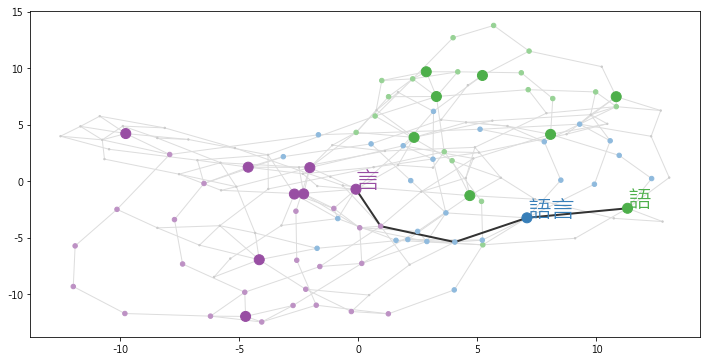

In [143]:
visualize_word("語言", sG)

{'word': '進口', 'word_sense': '進口-06631801', 'c1_sense': '進-06717002', 'c2_sense': '口-04084211', 'intersect': '進口-06631801', 'c1_pathlen': 5.611750960350037, 'c2_pathlen': 3.6584361791610718, 'c1w_dist': -0.014238706, 'c2w_dist': -0.30120802}


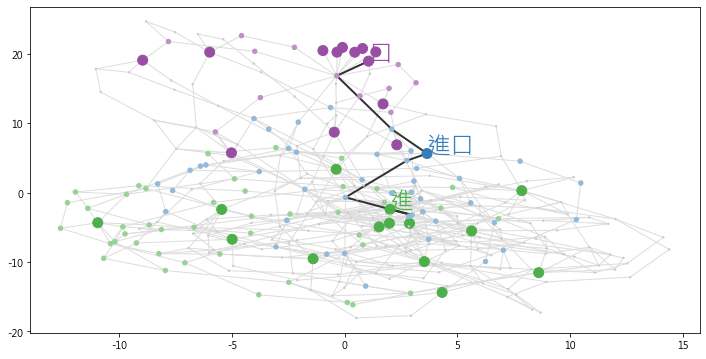

In [144]:
visualize_word("進口", sG)

{'word': '病毒', 'word_sense': '病毒-06602801', 'c1_sense': '病-06538801', 'c2_sense': '毒-06645103', 'intersect': '疾病-06523501', 'c1_pathlen': 2.787571668624878, 'c2_pathlen': 5.483305215835571, 'c1w_dist': 0.37436885, 'c2w_dist': 0.06881947}


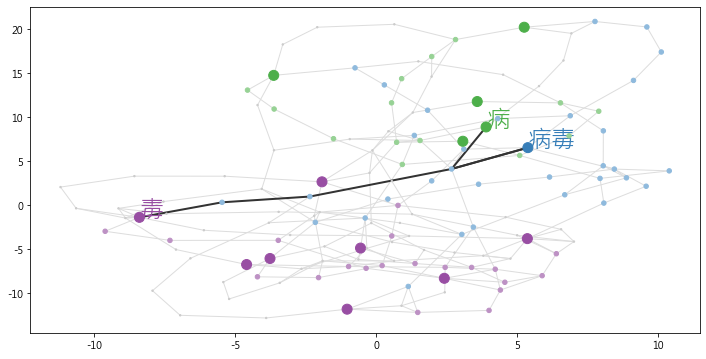

In [145]:
visualize_word("病毒", sG)